In [769]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

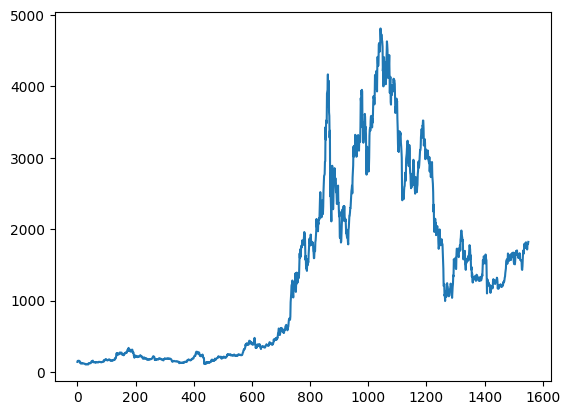

In [770]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('ETH-USD.csv')
df1=df.reset_index()['Close']
plt.plot(df1)


In [771]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [772]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]
print(df1)

[[0.00770764]
 [0.01073007]
 [0.00947408]
 ...
 [0.35867187]
 [0.35861566]
 [0.36483649]]


In [773]:
#in shape của từng tập dư liệu train, test, val
print("Train shape: ",train_data.shape)
print("Test shape: ",test_data.shape)
print("Val shape: ",val_data.shape)


Train shape:  (1085, 1)
Test shape:  (310, 1)
Val shape:  (156, 1)


In [774]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [775]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 50
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [776]:
# 7. Reshape input to be [samples, time steps, features] which is required for BNN
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [777]:
# 8. Import các thư viện cần thiết để xây dựng mô hình BNN (Bayesian Neural Network) với thư viện Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Thư viện tensorflow_probability cung cấp các hàm cần thiết xây dựng BNN
import tensorflow_probability as tfp
# Thư viện tensorflow_probability.distributions cung cấp các phân phối xác suất cần thiết xây dựng BNN
tfd = tfp.distributions
# Thư viện tensorflow_probability.layers cung cấp các lớp cần thiết xây dựng BNN
tfpl = tfp.layers
# Thêm drop-out vào Model
from tensorflow.keras.layers import Dropout
# Thêm Adam ( Adaptive Moment Estimation)  vào model
from tensorflow.keras.optimizers import Adam
# Thêm Dense vào model
from tensorflow.keras.layers import Dense

# Thêm flatten vào Model, flatten là một hàm được sử dụng để chuyển đổi một mảng nhiều chiều thành một mảng một chiều
from tensorflow.keras.layers import Flatten

# Thêm early vào Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

In [778]:
from tensorflow.keras import Sequential

In [779]:
# 9. Define BNN Model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

In [780]:
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

In [781]:
# 11. Train model
early_stop = EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(X_train, y_train, validation_data = (X_test, ytest), epochs=100,batch_size=64, verbose=1,callbacks=[early_stop])
# sẽ dừng lại khi val_loss không còn giảm nữa sau 50 lần lặp, monitor là giá trị để theo dõi, ở đây là val_loss
# verbose=1 sẽ in ra thông tin khi dừng lại

Epoch 1/100
17/17 [==============================] - 1s 12ms/step - loss: 0.0281 - val_loss: 0.0047
Epoch 2/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0179 - val_loss: 0.0038
Epoch 3/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0116 - val_loss: 0.0041
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0079 - val_loss: 0.0051
Epoch 5/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0040
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0027
Epoch 7/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 0.0026
Epoch 8/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0023
Epoch 9/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0055 - val_loss: 0.0040
Epoch 10/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0024
Epoch 11

In [782]:
# 12. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

# In shape của từng tập dư liệu
print(train_predict.shape, y_pred.shape, y_pred_val.shape)

4/4 [==============================] - 0s 3ms/step
(1034, 1) (259, 1) (105, 1)


In [783]:
# 13. In shape của từng tập dư liệu y real
print(y_train.shape, ytest.shape, yval.shape)


(1034,) (259,) (105,)


In [784]:
# 14. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

# in head
print(train_predict[:5])

[[190.6241 ]
 [191.93033]
 [192.94737]
 [194.46182]
 [196.69275]]


In [785]:
# 15. Chuẩn hóa ngược lại yval và ytest và y_train sau khi đã reshape
y_train = y_train.reshape(y_train.shape[0],1)
ytest = ytest.reshape(ytest.shape[0],1)
yval = yval.reshape(yval.shape[0],1)

y_train=scaler.inverse_transform(y_train)
ytest=scaler.inverse_transform(ytest)
yval=scaler.inverse_transform(yval)

#in head
print(y_train[:5])



[[149.554337]
 [146.130844]
 [149.092453]
 [158.795425]
 [135.852661]]


In [786]:
# 16. Đánh giá độ chính xác thuật toán bằng MAE va RMSE
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error


print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict[:,0]))
print('Test Mean Absolute Error:', mean_absolute_error(ytest, y_pred[:,0]))
print('Val Mean Absolute Error:', mean_absolute_error(yval, y_pred_val[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(ytest, y_pred[:,0])))
print('Val Root Mean Squared Error:',np.sqrt(mean_squared_error(yval, y_pred_val[:,0])))



Train Mean Absolute Error: 107.26255350725339
Test Mean Absolute Error: 137.6178673628137
Val Mean Absolute Error: 67.46810826927083
Train Root Mean Squared Error: 181.21771393965733
Test Root Mean Squared Error: 174.87803824038298
Val Root Mean Squared Error: 82.561043113086


In [787]:
# 17. Đánh giá model bằng MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return numpy.mean(numpy.abs((y_true - y_pred) / y_true)) * 100

print('Train Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_train[:,0], train_predict[:,0]))
print('Test Mean Absolute Percentage Error:', mean_absolute_percentage_error(ytest[:,0], y_pred[:,0]))
print('Val Mean Absolute Percentage Error:', mean_absolute_percentage_error(yval[:,0], y_pred_val[:,0]))
print('Train Score: %.2f MAPE' % (mean_absolute_percentage_error(y_train[:,0], train_predict[:,0])))
print('Test Score: %.2f MAPE' % (mean_absolute_percentage_error(ytest[:,0], y_pred[:,0])))
print('Val Score: %.2f MAPE' % (mean_absolute_percentage_error(yval[:,0], y_pred_val[:,0])))


Train Mean Absolute Percentage Error: 16.111815866075236
Test Mean Absolute Percentage Error: 7.17609386863445
Val Mean Absolute Percentage Error: 4.757323907993975
Train Score: 16.11 MAPE
Test Score: 7.18 MAPE
Val Score: 4.76 MAPE


In [788]:
# 18. Lấy time_step ngày cuối cùng của dữ liệu train để dự đoán 30 ngày tiếp theo
x_input = val_data[-time_step:].reshape(-1, 1)   #[-time_step:] lấy time_step phần tử cuối cùng của dữ liệu
print("x_input.shape = ", x_input.shape)

# Dự đoán 30 ngày tiếp theo
lst_output = []

i = 1  # Biến đếm để dừng vòng lặp while
while(i <= 30):
    print("-----------------")
    # Đưa về mảng 1 chiều
    list_input = x_input.reshape(1, -1)[0]
    # in ra x_input của ngày thứ i trong 30 ngày tiếp theo
    print("day ", i, " have input = ", list_input)

    # Dự đoán giá đóng của ngày tiếp theo
    x_input = x_input.reshape(1, time_step, 1) # reshape lại về dạng (1, time_step, 1)
    yhat = model.predict(x_input, verbose=0) # dự đoán giá đóng của ngày tiếp theo

    # in ra giá đóng của ngày thứ i trong 30 ngày tiếp theo
    print("day ",i," have output = ", yhat[0][0])

    # thêm giá đóng của ngày thứ i vào lst_output
    lst_output.append(yhat[0][0])

    # Xóa phần tử đầu tiên x_input
    x_input = np.delete(x_input, 0)
    # thêm yhat vào x_input
    x_input = np.append(x_input, yhat[0][0])
    # Tăng biến đếm lên 1
    i = i + 1


x_input.shape =  (50, 1)
-----------------
day  1  have input =  [0.29958964 0.3049125  0.29962459 0.29795328 0.30851275 0.33333899
 0.32618488 0.33780784 0.33717825 0.33497258 0.33948427 0.33000189
 0.32685701 0.32852288 0.3194522  0.31659333 0.3263441  0.32496531
 0.3189258  0.33114841 0.32772532 0.31112397 0.31064736 0.31012582
 0.31074821 0.30958719 0.30367225 0.2834011  0.2813825  0.29273843
 0.31561152 0.33473313 0.33966098 0.32960766 0.334076   0.35856211
 0.35201403 0.35709456 0.34641911 0.3615946  0.34692802 0.36364331
 0.34997159 0.34821271 0.3549916  0.34220025 0.35437746 0.35867187
 0.35861566 0.36483649]
day  1  have output =  0.3452041
-----------------
day  2  have input =  [0.3049125  0.29962459 0.29795328 0.30851275 0.33333899 0.32618488
 0.33780784 0.33717825 0.33497258 0.33948427 0.33000189 0.32685701
 0.32852288 0.3194522  0.31659333 0.3263441  0.32496531 0.3189258
 0.33114841 0.32772532 0.31112397 0.31064736 0.31012582 0.31074821
 0.30958719 0.30367225 0.2834011  0

In [789]:
# 19.In ra 30 ngày tiếp theo
print(lst_output)


[0.3452041, 0.341485, 0.33727962, 0.33366954, 0.33285227, 0.3331924, 0.33632186, 0.3306657, 0.33306268, 0.32842606, 0.3353471, 0.33595312, 0.33641875, 0.33744833, 0.33512816, 0.33123115, 0.32944462, 0.33322376, 0.32871577, 0.3323374, 0.33069274, 0.3283935, 0.32876235, 0.32952917, 0.32814497, 0.32643887, 0.3279592, 0.3269309, 0.3279498, 0.32768112]


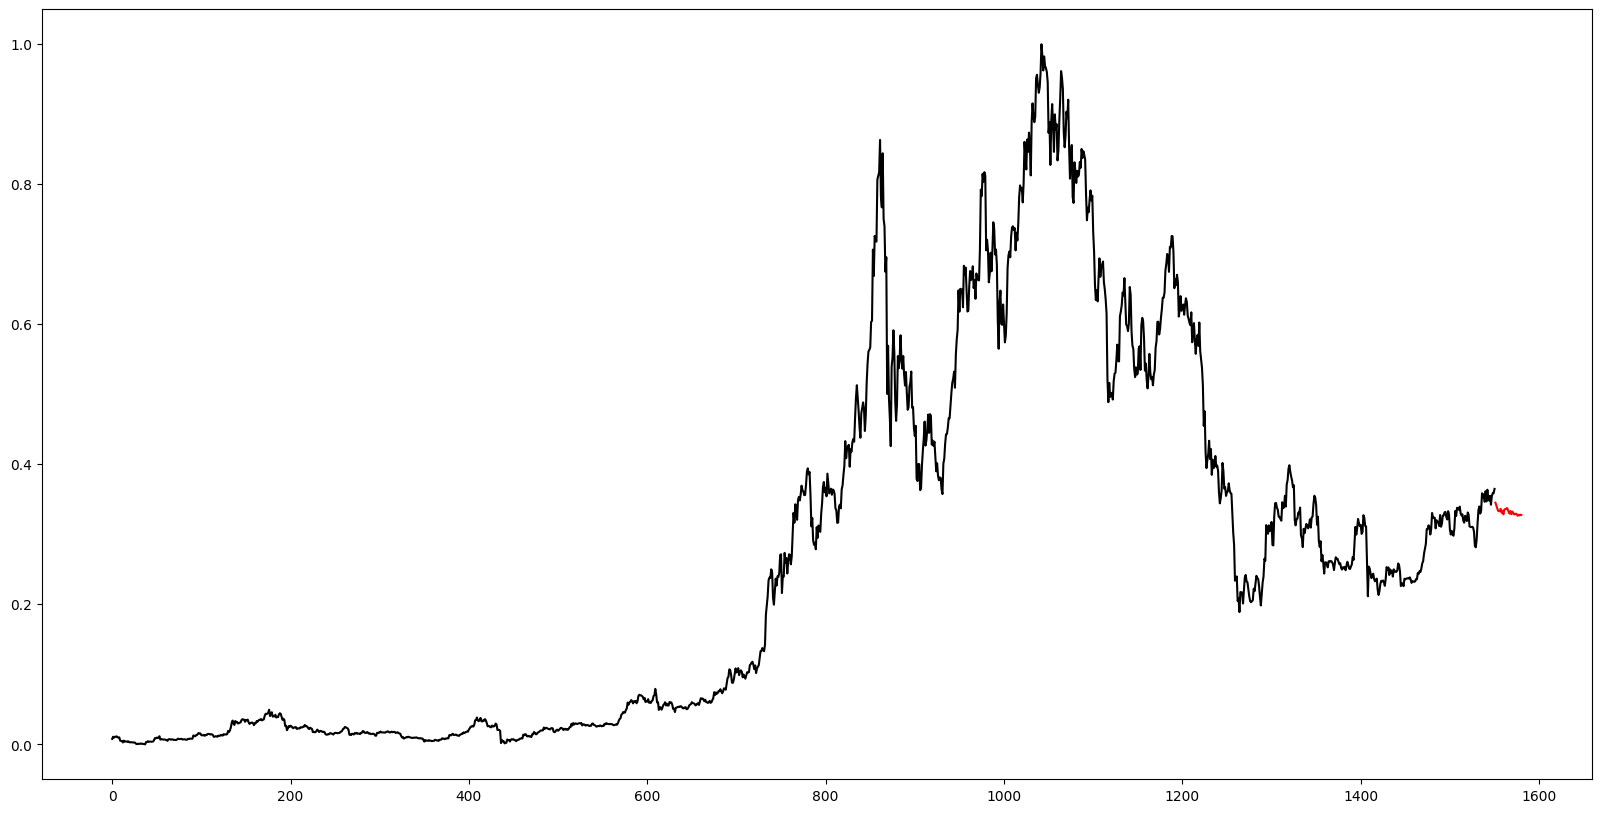

In [790]:
# 20. Tạo mảng index tương ứng với các ngày
days = np.array(range(len(df), len(df) + len(lst_output)))

# Vẽ biểu đồ
plt.figure(figsize=(20,10))
plt.plot(days, lst_output, c='r', label='Next 30 days')
plt.plot(df1, c='black', label='Real data')
plt.show()


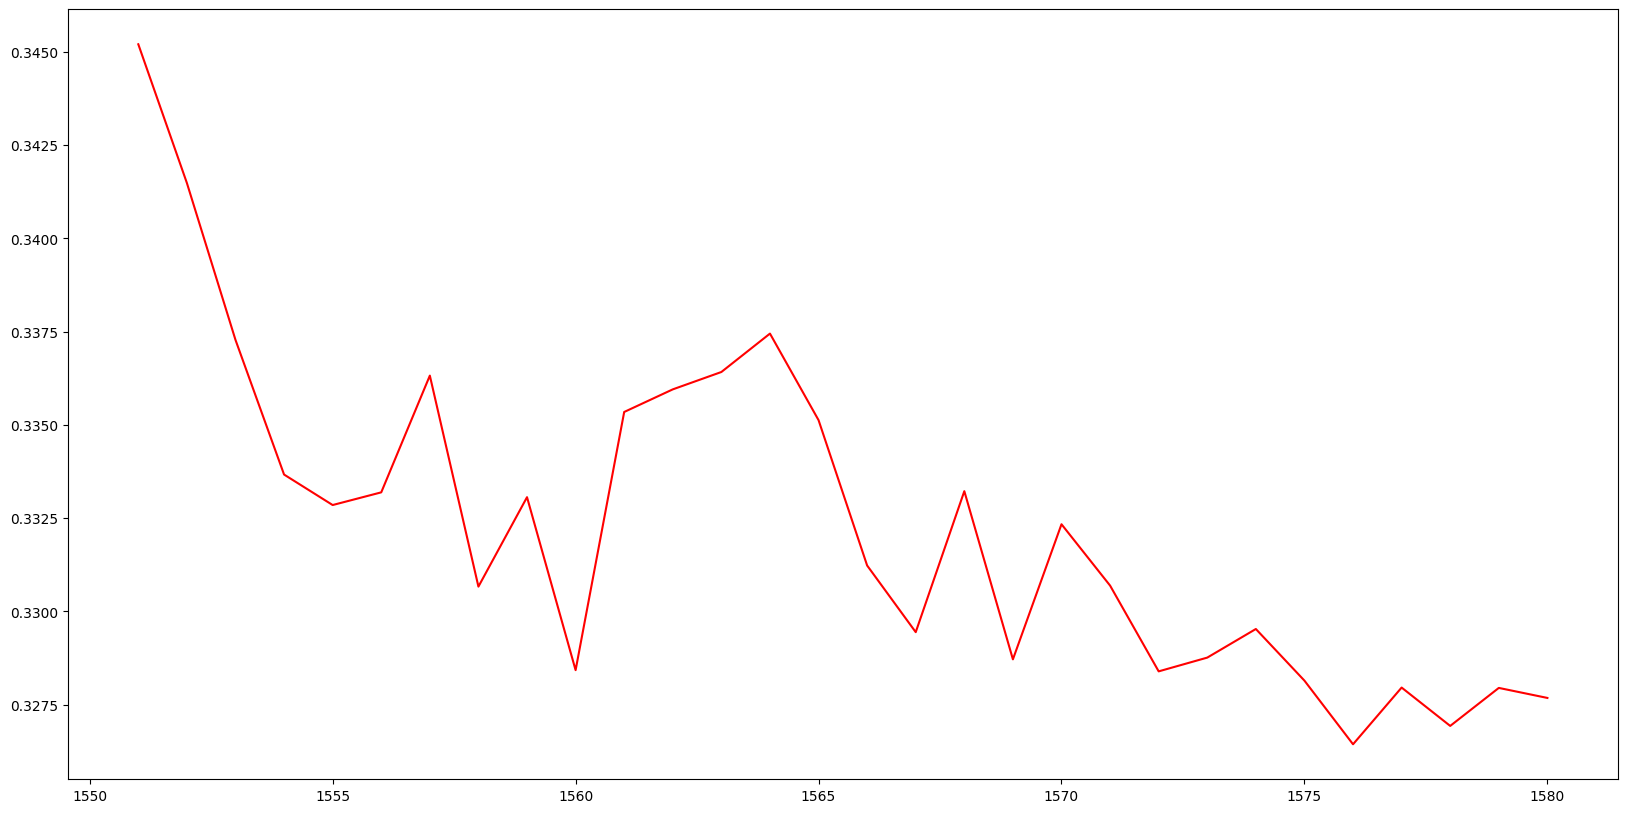

In [791]:
# 21.vẽ next 30 days
plt.figure(figsize=(20,10))
plt.plot(days, lst_output, c='r', label='Next 30 days')
plt.show()

In [792]:
# 22.Chuẩn hóa dữ liệu và chuyển đổi các giá trị dự đoán trở lại đơn vị ban đầu
train_data_inverse=scaler.inverse_transform(np.array(train_data).reshape(-1, 1))
test_data_inverse=scaler.inverse_transform(np.array(test_data).reshape(-1, 1))
val_data_inverse=scaler.inverse_transform(np.array(val_data).reshape(-1, 1))
next_30_days_inverse=scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

# in dữ liệu
print(train_data_inverse[:5])
print(test_data_inverse[:5])
print(val_data_inverse[:5])
print(next_30_days_inverse[:5])

[[140.819412]
 [155.047684]
 [149.13501 ]
 [154.58194 ]
 [155.638596]]
[[4020.26001 ]
 [3982.099609]
 [4108.015625]
 [4047.98291 ]
 [4093.281006]]
[[1514.374878]
 [1555.477905]
 [1619.698486]
 [1590.783325]
 [1572.714478]]
[[1729.6014]
 [1712.0936]
 [1692.2966]
 [1675.302 ]
 [1671.4547]]


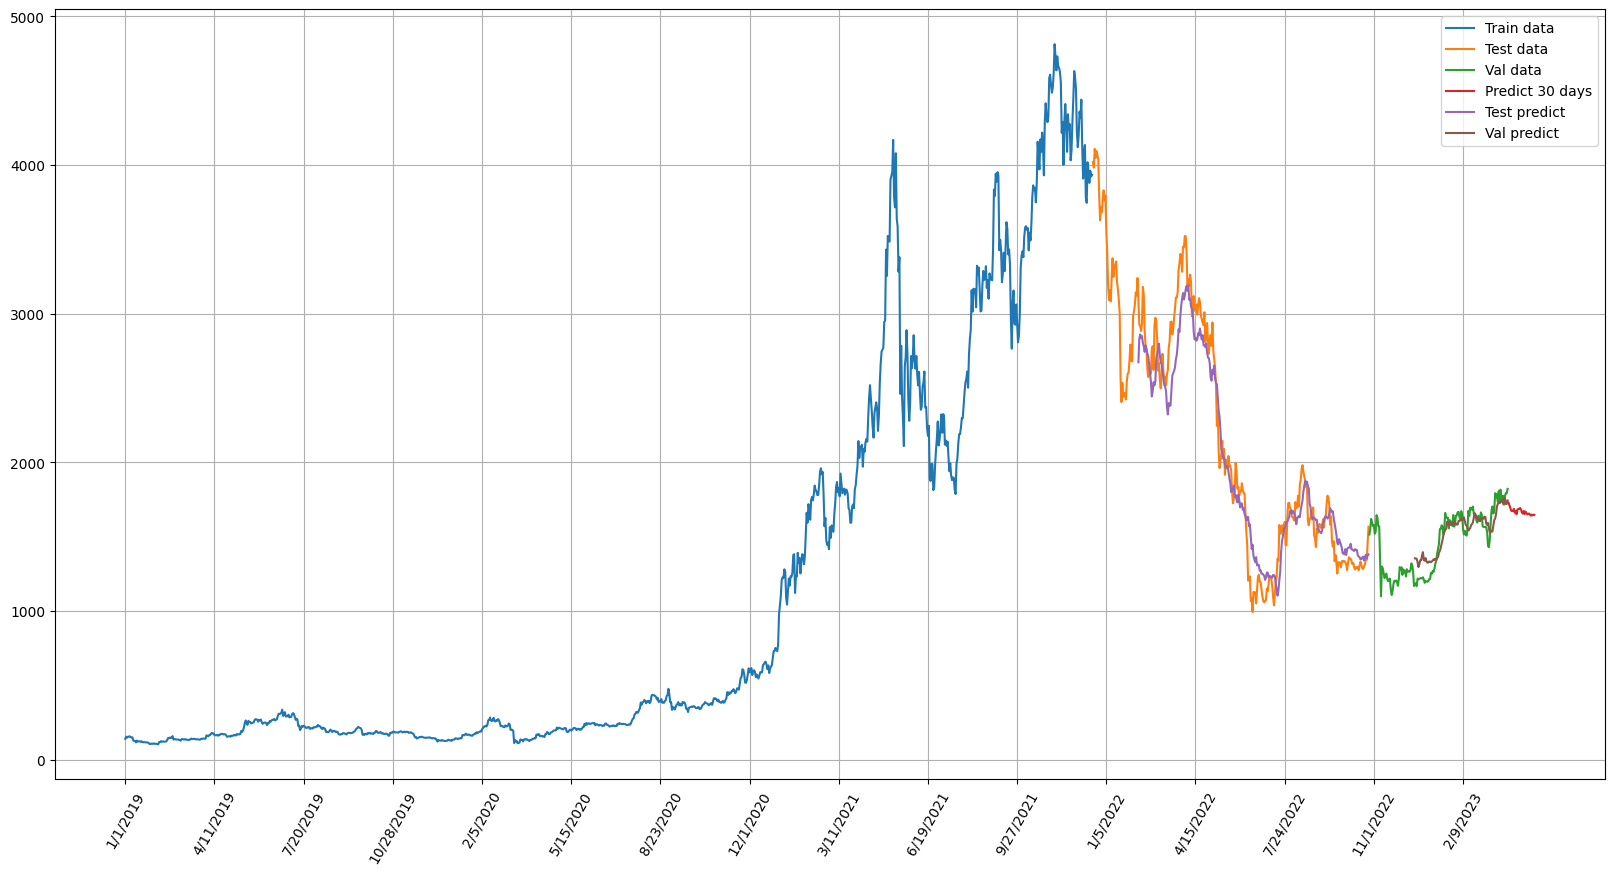

In [793]:
# 23 .vẽ y_train nối với ytest và y_val với index tương ứng

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
predict30_data_index = pd.RangeIndex(start=train_size+test_size+val_size, stop=train_size+test_size+val_size+30, step=1)

train_predict_index = pd.RangeIndex(start=0, stop=train_predict.shape[0], step=1)
y_pred_index = pd.RangeIndex(start=train_size+(train_size-train_predict.shape[0]), stop=train_size+(train_size-train_predict.shape[0])+y_pred.shape[0], step=1)
y_pred_val_index = pd.RangeIndex(start=train_size+(train_size-train_predict.shape[0])+y_pred.shape[0]+(val_size-y_pred_val.shape[0]), stop=train_size+(train_size-train_predict.shape[0])+y_pred.shape[0]+y_pred_val.shape[0]+(val_size-y_pred_val.shape[0]), step=1)
plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(train_data_index, train_data_inverse,  label='Train data')
plt.plot(test_data_index, test_data_inverse, label='Test data')
plt.plot(val_data_index, val_data_inverse,  label='Val data')
plt.plot(predict30_data_index, next_30_days_inverse, label='Predict 30 days')
plt.plot(y_pred_index, y_pred, label='Test predict')
plt.plot(y_pred_val_index, y_pred_val,  label='Val predict')
# trục x là giá trị của cột Close time của df1
plt.xticks(np.arange(0, len(df1), 100), df['Date'][0:len(df):100])
plt.xticks(rotation=60)
plt.legend()
plt.show()





In [794]:
# PHẦN THÊM : Đánh giá bằng R-Squared
from sklearn.metrics import r2_score
r_squared = r2_score(ytest, y_pred)
print("Test_R-squared: ", r_squared)
r_squared = r2_score(yval, y_pred_val)
print("Val_R-squared: ", r_squared)

Test_R-squared:  0.9417687465888361
Val_R-squared:  0.816118593747649
